In [1]:
import os
import time # optional 
import pandas as pd
import numpy as np
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pinecone # for vector database

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
input_datapath = './data/Reviews.csv'  # This dataset includes 500k reviews 
df = pd.read_csv(input_datapath, index_col=0)
df = df[['Time', 'ProductId', 'UserId', 'Score', 'Summary', 'Text']]
df = df.dropna()
df['combined'] = "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
df = df.sort_values('Time').tail(3_00) # Pick latest 300 reviews 
df.drop('Time', axis=1, inplace=True)

In [5]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") 
df['n_tokens'] = df.combined.apply(lambda x: len(tokenizer.encode(x))) #add number of tokens
df = df[df.n_tokens<8000].tail(3_00) # remove extra long text lines based on number of tokens
df['ada_similarity'] = df.combined.apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))

In [6]:
matrix = np.vstack(df.ada_similarity.values)
matrix.shape

(300, 1536)

In [7]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cluster
3    4.027778
2    4.045455
0    4.148649
1    4.637255
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

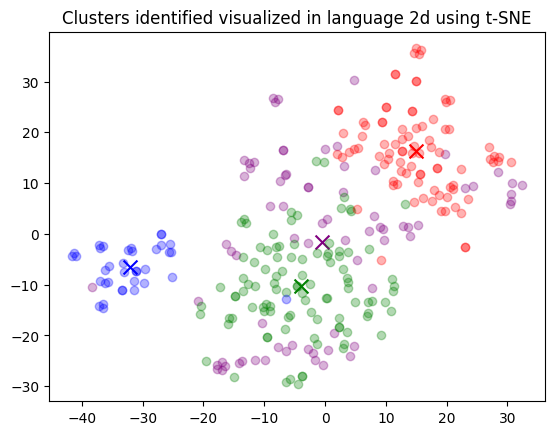

In [8]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [9]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model="davinci-002",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  "barbeque sauce" (1)- 1. Barbeque Sauce- 2. Barbeque Sauce- 3. Barbeque Sauce- 4. Barbeque Sauce- 5. Barbeque Sauce- 6. Barbeque Sauce-
5, Belongs in your kitchen:   Grapeseed oil is a healthy, light oil of very mild but pleasing flavor
4, Its LIGHT but very nice sweetener:   This Nectresse Sweetener is rather light in taste --but is very nice o
5, ZipFizz liquid energy shot:   Have used this for years.  Gives long lasting energy boost with no sud
1, Couldn't tell you how it tasted:   The bottle was not sealed, and when I opened the cover, there was blac
5, no complaints:   I'm a huge fan of Jack Daniel's jelly, <a href="http://www.amazon.com/
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cerea

# Vector DB

In [10]:
pinecone.init(
    api_key=os.getenv("PINECONE_API_KEY"),
    environment="us-west1-gcp")

In [21]:
index_name = 'test'
dimensions = 1536
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

TypeError: expected string or bytes-like object

In [20]:
pinecone.create_index(name=index_name, dimension=dimensions, metric="cosine")

TypeError: expected string or bytes-like object

In [ ]:
meta= [{'combined': line} for line in df['combined']]
vectors = list(zip(df['ProductId'], df['ada_similarity'], meta))

upsert_response = index.upsert(
    vectors=vectors,
    namespace=index_name, values=True, include_metadata=True)

In [ ]:
query = "I have ordered these raisins"
response = openai.Embedding.create(input=query, model='text-embedding-ada-002')
query_response_embeddings = response['data'][0]['embedding']

In [ ]:
vector_database_results_matching = index.query([query_response_embeddings], top_k=5, include_metadata=True, include_Values=True, 
    namespace=index_name)
for match in vector_database_results_matching['matches']:
    print(f"{match['score']:.2f}: {match['metadata']['combined']}")

In [23]:
import chromadb

In [24]:
client = chromadb.Client()

In [26]:
df.head()

,ProductId,UserId,Score,Summary,Text,combined,n_tokens,ada_similarity,Cluster
Id,,,,,,,,,
535731,B003VXHGDM,A3GFZIL1E0Z5V8,5,Rodeo Drive is Crazy Good Coffee!,Rodeo Drive is my absolute favorite and I'm re...,Title: Rodeo Drive is Crazy Good Coffee!; Cont...,59,"[-0.030126916244626045, -0.007889739237725735,...",2
449787,B006H33NL2,A1J0EO4EVI9ANK,5,Favorite chew toy!,This is the second one of these antlers that I...,Title: Favorite chew toy!; Content: This is th...,110,"[-0.013032538816332817, -0.008433197624981403,...",3
205938,B00005C2M2,A3IVNUHADVJKFA,5,Perfect Gift,I got these to give out in a goodie bag for th...,Title: Perfect Gift; Content: I got these to g...,57,"[-0.02611200325191021, -0.016329903155565262, ...",1
465192,B003VQXYMQ,A2QVLUH3RNRS7D,2,Bitter...,"This hot cocoa is drinkable, but the taste is ...",Title: Bitter...; Content: This hot cocoa is d...,42,"[-0.011938805691897869, -0.01731126941740513, ...",2
75882,B002W1F6TK,ANSBPV2CZVZ39,1,terrible treats,My dogs love them but they are loaded with jun...,Title: terrible treats; Content: My dogs love ...,63,"[-0.022628329694271088, -0.02952086739242077, ...",3


In [27]:
for row in df.iterrows():
    print(row)

(535731, ProductId                                                B003VXHGDM
UserId                                               A3GFZIL1E0Z5V8
Score                                                             5
Summary                           Rodeo Drive is Crazy Good Coffee!
Text              Rodeo Drive is my absolute favorite and I'm re...
combined          Title: Rodeo Drive is Crazy Good Coffee!; Cont...
n_tokens                                                         59
ada_similarity    [-0.030126916244626045, -0.007889739237725735,...
Cluster                                                           2
Name: 535731, dtype: object)
(449787, ProductId                                                B006H33NL2
UserId                                               A1J0EO4EVI9ANK
Score                                                             5
Summary                                          Favorite chew toy!
Text              This is the second one of these antlers that I...
c

In [32]:
row[1]

ProductId                                                B001EQ5GEO
UserId                                               A3VYU0VO6DYV6I
Score                                                             5
Summary                                         I love Maui Coffee!
Text              My first experience with Maui Coffee was bring...
combined          Title: I love Maui Coffee!; Content: My first ...
n_tokens                                                        125
ada_similarity    [-0.006159266456961632, -0.015069019980728626,...
Cluster                                                           2
Name: 542497, dtype: object

In [33]:
ids = []
metadatas = []
embeddings = []

for row in df.iterrows():
    index = row[0]
    text = row[1].Text
    summary = row[1].Summary
    
    metadata = {
        "Context": text,
        "Summary": summary
    }
    
    embedding = row[1].ada_similarity
    
    ids.append(str(index))
    metadatas.append(metadata)
    embeddings.append(embedding)
    
# chunk_size = 1024  # 한 번에 처리할 chunk 크기 설정
# total_chunks = len(embeddings) // chunk_size + 1  # 전체 데이터를 chunk 단위로 나눈 횟수
# embeddings = [ e.tolist() for e in tqdm(embeddings)]  

# for chunk_idx in tqdm(range(total_chunks)):
#     start_idx = chunk_idx * chunk_size
#     end_idx = (chunk_idx + 1) * chunk_size
    
#     # chunk 단위로 데이터 자르기
#     chunk_embeddings = embeddings[start_idx:end_idx]
#     chunk_ids = ids[start_idx:end_idx]
#     chunk_metadatas = metadatas[start_idx:end_idx]
    
#     # chunk를 answers에 추가
#     answers.add(embeddings=chunk_embeddings, ids=chunk_ids, metadatas=chunk_metadatas)

In [49]:
result = text(
    # query_embeddings=model.encode("어제 여자친구랑 헤어졌다", normalize_embeddings=True).tolist(),
    query_embeddings = openai.Embedding.create(input="어제 여자친구랑 헤어졌다", model='text-embedding-ada-002')['data'][0]['embedding'],
    n_results=3
)

print(result)

TypeError: 'str' object is not callable

In [51]:
query_embeddings = openai.Embedding.create(input="어제 여자친구랑 헤어졌다", model='text-embedding-ada-002')['data'][0]['embedding']

In [52]:
query_embeddings

[-0.017103049904108047,
 0.006331669632345438,
 0.01021723635494709,
 -0.022952713072299957,
 -0.002423150697723031,
 0.005813594441860914,
 -0.007751458790153265,
 -0.0003768753376789391,
 0.006774329114705324,
 -0.02081483229994774,
 -0.002282155444845557,
 0.0013165019918233156,
 0.0015230764402076602,
 -0.020526282489299774,
 -0.018690066412091255,
 -0.009312243200838566,
 0.026179209351539612,
 -0.024290528148412704,
 0.017719494178891182,
 -0.027858035638928413,
 0.020775483921170235,
 -0.018257243558764458,
 -0.005203708074986935,
 0.005180755164474249,
 -0.016827616840600967,
 0.010335278697311878,
 0.018086737021803856,
 -0.03265843167901039,
 -0.0006521029863506556,
 -0.0023133056238293648,
 0.0245528444647789,
 0.007305520586669445,
 -0.013338805176317692,
 0.012722360901534557,
 -0.033078137785196304,
 -0.019017962738871574,
 -0.005485698580741882,
 0.006174279842525721,
 -0.011456682346761227,
 0.005118454806506634,
 0.0014370037242770195,
 -0.028776144608855247,
 0.000612